### Import the datasets

In [104]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random 

%matplotlib inline

SEED = 2147483647

# read all the names in a python list
with open(file="datasets/names.txt", mode="r") as namesTxt: 
    # names = [line[:-1] for line in namesTxt.readlines()]
    names = namesTxt.read().splitlines()
names[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

### Build the datasets

In [105]:
# create the encoder for the letters
chars = ["."] + sorted(list(set("".join(names)))) 
stoi = {c:i for i,c in enumerate(chars)}
itos = {i:c for i,c in enumerate(chars)}
vocab_size = len(stoi)

# define the block size of the model
block_size = 3 # context length: how many characters to we consider to predict the next one

# helper function to encode the datasets
def buildDatasets(words):
    X, Y = [], []
    
    for word in words:
        context = [0] * block_size
        for ch in word + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    return (torch.tensor(X),torch.tensor(Y))

# shuffle the order of the names
random.seed(42)
random.shuffle(names)
n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))

# build the datasets
xtrain, ytrain = buildDatasets(names[:n1]) # 80%
xtest, ytest = buildDatasets(names[n1:n2]) # 10%
xdev, ydev = buildDatasets(names[n2:]) # 10 %

### Create MLP

In [114]:
# define the parameters of the MLP
n_embd = 10 # the dimentionality of the character embedding vectors
n_hidden = 200 # the number of hidden layers
g = torch.Generator().manual_seed(SEED) 

# initialization
C = torch.randn(size = (vocab_size, n_embd), generator = g) 
w1 = torch.randn(size=(n_embd * block_size, n_hidden), generator = g) * ((5/3) / ((n_embd * block_size)**0.5))
b1 = torch.randn(size=(n_hidden,), generator=g) * 0.01
w2 = torch.randn(size=(n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(size=(vocab_size,), generator=g) * 0
bngain = torch.ones((1, n_hidden))
bnbiais = torch.zeros((1,n_hidden))
bnmean = torch.zeros((1, n_hidden))
bnstd = torch.ones((1, n_hidden))

parameters = [C, w1, b1, w2, b2, bngain, bnbiais]
# parameters = [C, w1, b1, w2, b2]

for p in parameters:
    p.requires_grad = True
print(f"Number of parameters of the MLP = {sum(p.nelement() for p in parameters)}")

Number of parameters of the MLP = 12297


### Train MLP

The loss of the batch Nr.0 = 3.3071
The loss of the batch Nr.10000 = 2.1460
The loss of the batch Nr.20000 = 2.1070
The loss of the batch Nr.30000 = 2.2767
The loss of the batch Nr.40000 = 2.3411
The loss of the batch Nr.50000 = 2.0462
The loss of the batch Nr.60000 = 2.0626
The loss of the batch Nr.70000 = 2.1069
The loss of the batch Nr.80000 = 2.1328
The loss of the batch Nr.90000 = 1.9771


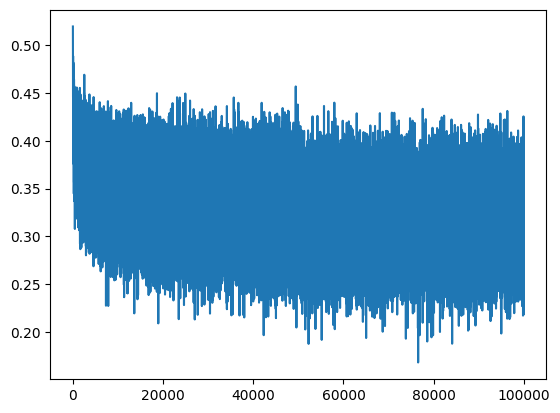

In [115]:
# training parameters
max_path = 100000
batch_size = 32
lossi = []
xtrain_len = xtrain.shape[0]

# forward pass
for i in range(max_path):
# for i in range(1):

	# prepare the data of the training batch
	ix = torch.randint(low = 0, high=xtrain_len, size=(batch_size,), generator=g)
	xbatch, ybatch = xtrain[ix], ytrain[ix]

	# forward pass
	emb = C[xbatch] # embed the characters into tensor
	embcat = emb.view(emb.shape[0], -1) # concatenate the tensors
	hpreact = embcat @ w1 + b1 # pass through the first hidden layer
	bnmeani = hpreact.mean(0, keepdim=True) # the mean of this batch
	bnstdi = hpreact.std(0, keepdim=True) # the standard deviation of this batch
	hpreact = bngain * ((hpreact - bnmeani)/(bnstdi)) + bnbiais # normalize the batch
	with torch.no_grad():
		bnmean = 0.999 * bnmean + 0.001 * bnmeani # update estimate of global mean
		bnstd = 0.999 * bnstd + 0.001 * bnstdi # update estimate of global standard deviation
	h = torch.tanh(hpreact) # activation function of the first layer
	logits = h @ w2 + b2 # output layer
	loss = F.cross_entropy(logits, ybatch) # loss function of this batch

	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()

	# update the weights
	lr = 0.1 if i<50000 else 0.01
	# lr = 0.05 if i<10000 else 0.01
	for p in parameters:
		p.data += - lr * p.grad
  
	# print the results once in a while
	if i % 10000 == 0:
		print(f"The loss of the batch Nr.{i} = {loss.item():.4f}")
	lossi.append(loss.log10().item())
 
	# break

# print the evolution of the loss
plt.plot(lossi)

### Helper function to calculate the loss of a dataset

In [116]:
@torch.no_grad() # disable the operation gradient tracking
def print_loss(dataset):
	dic = {
		"train": (xtrain, ytrain),
		"dev": (xdev, ydev),
		"test": (xtest, ytest)
	}
	X, Y = dic[dataset]
	emb = C[X] # embed the characters into tensor
	embcat = emb.view(emb.shape[0], -1) # concatenate the tensors
	hpreact = embcat @ w1 + b1 # pass through the first hidden layer
	hpreact = bngain * ((hpreact - bnmean)/(bnstd)) + bnbiais
	h = torch.tanh(hpreact) # activation function of the first layer
	logits = h @ w2 + b2 # output layer
	loss = F.cross_entropy(logits, Y) # loss function of this batch
	print(f"{dataset} loss = {loss}")
print_loss("train")
print_loss("dev")

train loss = 2.0696568489074707
dev loss = 2.1090638637542725


### Predict new names

In [118]:
# predict names
newNames = []
for i in range (10):
	newName = ""
	context = [0] * block_size
	while True:
		emb = C[context] # embed the characters into tensor
		embcat = emb.view(30) # concatenate the tensors
		hpreact = embcat @ w1 + b1 # pass through the first hidden layer
		hpreact = bngain * ((hpreact - bnmean)/(bnstd)) + bnbiais
		h = torch.tanh(hpreact) # activation function of the first layer
		logits = h @ w2 + b2 # output layer
		proba = logits.exp() / logits.exp().sum()

		i_out = torch.multinomial(
			input=proba,
			num_samples=1,
			replacement=True,
			generator=g,
		).item()

		context = context[1:] + [i_out]
		newName += itos[i_out]

		if i_out == 0:
			break		
	newNames.append(newName)

for name in newNames:
    print(name[:-1])

hara
lan
caliiah
antrevryn
shri
ristynra
dai
ely
arrieleio
raylynn
